# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera. Belén León Pérez.

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results](#results)
* [Discussion](#discusion)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find a location for a new Italian restaurant in Barcelona, Spain. This project is targeted to people who want to open a Italian restaurant there.

We choose Barcelona because it is one of the most visited cities in the world by international visitors.

So, in order to find an optimal location in Barcelona we will try to find locations that are not already crowded with restaurants. We are interested in areas with no Italian restaurants near.

We will use the different tools seen in the previous courses to find a few neighborhoods based on this criteria. 

## Data <a name="data"></a>

The factors that will influence our decission are:
* number of restaurants in each neighborhood 
* number of Italian restaurants and distance to them in each neighborhood

Following data sources will be needed to extract/generate the required information:
* Barcelona’s last published area of the neighborhoods of the city of Barcelona https://opendata-ajuntament.barcelona.cat/data/es/dataset/est-superficie/resource/9cd3d989-03c2-4e39-b3a7-eec0eac53e9f
* Coordinates of the neighborhoods, we will use Nominatim to Geocode it.
* number of restaurants and their type and location in every neighborhood will be obtained using Foursquare API.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [ ]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

import random # library for random number generation
import numpy as np # library for vectorized computation


import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs
from yellowbrick.cluster import KElbowVisualizer

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors


import folium # map rendering library

import pyproj

import math

For the Barcelona neighborhood data, we will extract the information from: https://opendata-ajuntament.barcelona.cat/data/es/dataset/est-superficie/resource/9cd3d989-03c2-4e39-b3a7-eec0eac53e9f

In [2]:
d = pd.read_csv(".../2019_superficie.csv")
d=d.drop(['Any', 'Superfície (ha)'], axis=1)
d.head(10)


,Codi_Districte,Nom_Districte,Codi_Barri,Nom_Barri
0,1,Ciutat Vella,1,el Raval
1,1,Ciutat Vella,2,el Barri Gòtic
2,1,Ciutat Vella,3,la Barceloneta
3,1,Ciutat Vella,4,"Sant Pere, Santa Caterina i la Ribera"
4,2,Eixample,5,el Fort Pienc
5,2,Eixample,6,la Sagrada Família
6,2,Eixample,7,la Dreta de l'Eixample
7,2,Eixample,8,l'Antiga Esquerra de l'Eixample
8,2,Eixample,9,la Nova Esquerra de l'Eixample
9,2,Eixample,10,Sant Antoni


This data set doesn’t have the coordinates so we used Nominatim to Geocode the Neighbourhoods

In [3]:
geolocator=Nominatim(user_agent='bcn_geocoder')
lon=[]
lat=[]
for index, row in d.iterrows():
 location=geolocator.geocode(row['Nom_Barri']+',Barcelona')
 lon.append(location.longitude)
 lat.append(location.latitude)


In [4]:
d['Latitude']=lat
d['Longitude']=lon
d.head()
d.drop(columns=["Codi_Districte","Codi_Barri"])

,Nom_Districte,Nom_Barri,Latitude,Longitude
0,Ciutat Vella,el Raval,41.379518,2.168368
1,Ciutat Vella,el Barri Gòtic,41.383395,2.176912
2,Ciutat Vella,la Barceloneta,41.380653,2.189927
3,Ciutat Vella,"Sant Pere, Santa Caterina i la Ribera",41.388076,2.183398
4,Eixample,el Fort Pienc,41.395925,2.182325
...,...,...,...,...
68,Sant Martí,Diagonal Mar i el Front Marítim del Poblenou,41.405228,2.213352
69,Sant Martí,el Besòs i el Maresme,41.414979,2.213877
70,Sant Martí,Provençals del Poblenou,41.411948,2.204125
71,Sant Martí,Sant Martí de Provençals,41.416519,2.198968


In [5]:
d.shape

(73, 6)

Also, we create a map of Toronto to see the neighborhood

In [6]:
address = 'Barcelona, Spain'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of BArcelona are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of BArcelona are 41.3828939, 2.1774322.


In [7]:
map_bcn = folium.Map(location=[latitude, longitude], zoom_start=11
                    )

# add markers to map
for lat, lng, districte, neighborhood_bcn in zip(d['Latitude'], d['Longitude'], d['Nom_Districte'], d['Nom_Barri']):
    label = '{}, {}'.format(neighborhood_bcn, districte)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bcn)  
    
map_bcn

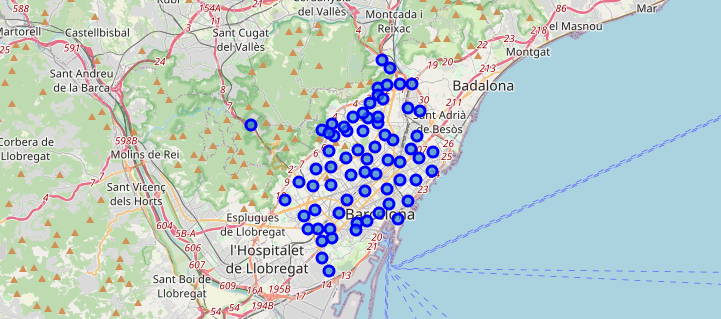

Now let's define a query to search for Restaurants in Barcelona.

In [8]:

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']



In [9]:
# I removed my credentials


In [10]:
def getNearbyRestaurants(names, latitudes, longitudes, radius=500):
    
    #venues_list=[]
    restaurant=pd.DataFrame(columns=['name', 'categories','adress','lat','lng','labeledLatLngs','distance','postalCode','cc','city','state','country','formattedAddress','crossStreet','id'])
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={}, {}&access_token={}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            ACCESS_TOKEN,
            version,
            query,
            radius, 
            LIMIT)
            
        # make the GET request
        results1 = requests.get(url).json()

        # assign relevant part of JSON to venues
        venues = results1['response']['venues']
        

# tranform venues into a dataframe
    
        dataframe_restaurant=pd.json_normalize(venues)
        
        if len(dataframe_restaurant.columns)!= 0:
        
            filtered_columns = ['name', 'categories'] + [col for col in dataframe_restaurant.columns if col.startswith('location.')] + ['id']
            
            dataframe_filtered_restaurant= dataframe_restaurant.loc[:, filtered_columns]
        
            dataframe_filtered_restaurant['categories'] = dataframe_filtered_restaurant.apply(get_category_type, axis=1)
        
# clean column names by keeping only last term
            dataframe_filtered_restaurant.columns = [column.split('.')[-1] for column in dataframe_filtered_restaurant.columns]

        
        # return only relevant information for each nearby venue
           #venues_list.append(dataframe_filtered_restaurant)
            restaurant=pd.concat([dataframe_filtered_restaurant, restaurant], ignore_index=True)
    
    return(restaurant)

In [11]:
bcn_restaurant= getNearbyRestaurants(names=d['Nom_Barri'],
                                   latitudes=d['Latitude'],
                                   longitudes=d['Longitude']
                                  )

el Raval
el Barri Gòtic
la Barceloneta
Sant Pere, Santa Caterina i la Ribera
el Fort Pienc
la Sagrada Família
la Dreta de l'Eixample
l'Antiga Esquerra de l'Eixample
la Nova Esquerra de l'Eixample
Sant Antoni
el Poble Sec
la Marina del Prat Vermell
la Marina de Port
la Font de la Guatlla
Hostafrancs
la Bordeta
Sants - Badal
Sants
les Corts
la Maternitat i Sant Ramon
Pedralbes
Vallvidrera, el Tibidabo i les Planes
Sarrià
les Tres Torres
Sant Gervasi - la Bonanova
Sant Gervasi - Galvany
el Putxet i el Farró
Vallcarca i els Penitents
el Coll
la Salut
la Vila de Gràcia
el Camp d'en Grassot i Gràcia Nova
el Baix Guinardó
Can Baró
el Guinardó
la Font d'en Fargues
el Carmel
la Teixonera
Sant Genís dels Agudells
Montbau
la Vall d'Hebron
la Clota
Horta
Vilapicina i la Torre Llobeta
Porta
el Turó de la Peira
Can Peguera
la Guineueta
Canyelles
les Roquetes
Verdun
la Prosperitat
la Trinitat Nova
Torre Baró
Ciutat Meridiana
Vallbona
la Trinitat Vella
Baró de Viver
el Bon Pastor
Sant Andreu
la Sagrer

In [12]:
bcn_restaurant.head(10)

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,neighborhood,city,state,country,formattedAddress,crossStreet,id,adress
0,Restaurant Sant Martí,Mediterranean Restaurant,"Pont del Treball, 11",41.421829,2.197056,"[{'label': 'display', 'lat': 41.42182899788430...",515,08020,ES,Sant Martí de Provençals,Barcelona,Cataluña,España,"[Pont del Treball, 11, 08020 Barcelona Cataluñ...",NaN,4bb9d2a898c7ef3b64563202,NaN
1,Restaurant Mercurio,Coffee Shop,Santander 42,41.427242,2.202099,"[{'label': 'display', 'lat': 41.42724192958973...",453,NaN,ES,NaN,Barcelona,Cataluña,España,"[Santander 42, Barcelona Cataluña, España]",NaN,506434d9e4b05ef2f2fa6808,NaN
2,Bar Restaurant Plaza Verneda,Restaurant,NaN,41.423731,2.200806,"[{'label': 'display', 'lat': 41.423731, 'lng':...",187,NaN,ES,NaN,NaN,NaN,España,[España],NaN,52d931f6498ee2cbb59ca4aa,NaN
3,Restaurante Casa Suso,Food,"Carrer de ca n'Oliva, 69",41.424102,2.204519,"[{'label': 'display', 'lat': 41.42410237086280...",164,08020,ES,NaN,Barcelona,Cataluña,España,"[Carrer de ca n'Oliva, 69, 08020 Barcelona Cat...",NaN,4e1eeff7ae60cd553debd533,NaN
4,Restaurante Chino Ta viang dao,Asian Restaurant,NaN,41.421795,2.205835,"[{'label': 'display', 'lat': 41.42179497479602...",289,NaN,ES,NaN,NaN,NaN,España,[España],NaN,51af3519498ee8754e5f22e3,NaN
5,Restaurante Jordi Y Carlos,Café,"Carrer de Santander, 53",41.426792,2.201302,"[{'label': 'display', 'lat': 41.42679227766013...",420,08020,ES,NaN,Barcelona,Cataluña,España,"[Carrer de Santander, 53 (Binefar, 8), 08020 B...","Binefar, 8",4d2d7063f728b60ce9989afd,NaN
6,Bar Restaurante La Maro,Tapas Restaurant,80 Carrer de Menorca,41.420915,2.198806,"[{'label': 'display', 'lat': 41.420915, 'lng':...",430,08020,ES,NaN,Barcelona,Cataluña,España,"[80 Carrer de Menorca, 08020 Barcelona Cataluñ...",NaN,59e1280cad910e104c13d45f,NaN
7,Bar Restaurante Ziralla,None,NaN,41.422055,2.197821,"[{'label': 'display', 'lat': 41.42205462641505...",446,NaN,ES,NaN,Barcelona,Cataluña,España,"[Barcelona Cataluña, España]",NaN,4dfe0643a809d61e2fc51c51,NaN
8,Restaurant Sant Martí,Mediterranean Restaurant,"Pont del Treball, 11",41.421829,2.197056,"[{'label': 'display', 'lat': 41.42182899788430...",612,08020,ES,Sant Martí de Provençals,Barcelona,Cataluña,España,"[Pont del Treball, 11, 08020 Barcelona Cataluñ...",NaN,4bb9d2a898c7ef3b64563202,NaN
9,Bar Restaurant El Meson,Spanish Restaurant,"Gran Via, 1052",41.415977,2.198804,"[{'label': 'display', 'lat': 41.415977, 'lng':...",61,08020,ES,NaN,Barcelona,Cataluña,España,"[Gran Via, 1052, 08020 Barcelona Cataluña, Esp...",NaN,4d8a01065ecdf04de42bb58a,NaN


In [13]:
bcn_restaurant.shape

(1513, 17)

## Italian food venues

Now let's define a query to search for Restaurants in Barcelona.

In [14]:
def getNearbyItalian(names, latitudes, longitudes, radius=500):
    query='Italian'
    #venues_list=[]
    italian=pd.DataFrame(columns=['name', 'categories','adress','lat','lng','labeledLatLngs','distance','postalCode','cc','city','state','country','formattedAddress','crossStreet','id'])
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={}, {}&access_token={}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, 
            lng, 
            ACCESS_TOKEN,
            version,
            query,
            radius, 
            LIMIT)
            
        # make the GET request
        results1 = requests.get(url).json()

        # assign relevant part of JSON to venues
        venues = results1['response']['venues']

# tranform venues into a dataframe
    
        dataframe_restaurant=pd.json_normalize(venues)
        
        if len(dataframe_restaurant.columns)!= 0:
        
             filtered_columns = ['name', 'categories'] + [col for col in dataframe_restaurant.columns if col.startswith('location.')] + ['id']
            
             dataframe_filtered_restaurant= dataframe_restaurant.loc[:, filtered_columns]
        
             dataframe_filtered_restaurant['categories'] = dataframe_filtered_restaurant.apply(get_category_type, axis=1)
        
# clean column names by keeping only last term
             dataframe_filtered_restaurant.columns = [column.split('.')[-1] for column in dataframe_filtered_restaurant.columns]

        
        # return only relevant information for each nearby venue
           #venues_list.append(dataframe_filtered_restaurant)
             italian=pd.concat([dataframe_filtered_restaurant, italian], ignore_index=True)
           
    return(italian)

In [15]:
bcn_italian= getNearbyItalian(names=d['Nom_Barri'],
                                   latitudes=d['Latitude'],
                                   longitudes=d['Longitude']
                                  )

el Raval
el Barri Gòtic
la Barceloneta
Sant Pere, Santa Caterina i la Ribera
el Fort Pienc
la Sagrada Família
la Dreta de l'Eixample
l'Antiga Esquerra de l'Eixample
la Nova Esquerra de l'Eixample
Sant Antoni
el Poble Sec
la Marina del Prat Vermell
la Marina de Port
la Font de la Guatlla
Hostafrancs
la Bordeta
Sants - Badal
Sants
les Corts
la Maternitat i Sant Ramon
Pedralbes
Vallvidrera, el Tibidabo i les Planes
Sarrià
les Tres Torres
Sant Gervasi - la Bonanova
Sant Gervasi - Galvany
el Putxet i el Farró
Vallcarca i els Penitents
el Coll
la Salut
la Vila de Gràcia
el Camp d'en Grassot i Gràcia Nova
el Baix Guinardó
Can Baró
el Guinardó
la Font d'en Fargues
el Carmel
la Teixonera
Sant Genís dels Agudells
Montbau
la Vall d'Hebron
la Clota
Horta
Vilapicina i la Torre Llobeta
Porta
el Turó de la Peira
Can Peguera
la Guineueta
Canyelles
les Roquetes
Verdun
la Prosperitat
la Trinitat Nova
Torre Baró
Ciutat Meridiana
Vallbona
la Trinitat Vella
Baró de Viver
el Bon Pastor
Sant Andreu
la Sagrer

Let's check the first 10 rows

In [16]:
bcn_italian.head(10)

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id,crossStreet,neighborhood,adress
0,Sports Bar Italian Food,Pizza Place,Diagonal 123,41.406713,2.201637,"[{'label': 'display', 'lat': 41.40671334153134...",618,08005,ES,Barcelona,Cataluña,España,"[Diagonal 123, 08005 Barcelona Cataluña, España]",570793fccd10f15c2f66940b,NaN,NaN,NaN
1,ristoante italian fusion,Italian Restaurant,NaN,41.410623,2.213432,"[{'label': 'display', 'lat': 41.410623, 'lng':...",486,NaN,ES,NaN,NaN,España,[España],57ab4762498ea54ad096686e,NaN,NaN,NaN
2,Italian District,Italian Restaurant,169 Carrer de Llull,41.400361,2.201006,"[{'label': 'display', 'lat': 41.400361, 'lng':...",63,08005,ES,Barcelona,Cataluña,España,"[169 Carrer de Llull, 08005 Barcelona Cataluña...",5b77197e2619ee002c43b0ef,NaN,NaN,NaN
3,Dino Gelato Italiano,Ice Cream Shop,NaN,41.400934,2.201062,"[{'label': 'display', 'lat': 41.40093365860656...",71,NaN,ES,NaN,NaN,España,[España],536287a9498e043ce147ebc6,NaN,NaN,NaN
4,Argento Joyeria Italiana,Jewelry Store,Cigne 18,41.392172,2.197077,"[{'label': 'display', 'lat': 41.39217159838907...",257,NaN,ES,NaN,NaN,España,"[Cigne 18, España]",508572aee4b00dbb9f197077,NaN,NaN,NaN
5,Gastronomia Italiana,Deli / Bodega,NaN,41.408988,2.185408,"[{'label': 'display', 'lat': 41.408988, 'lng':...",464,08026,ES,Barcelona,Cataluña,España,"[08026 Barcelona Cataluña, España]",5c46155689e490002caefd03,NaN,NaN,NaN
6,Gastronomia Italiana,Deli / Bodega,NaN,41.408988,2.185408,"[{'label': 'display', 'lat': 41.408988, 'lng':...",292,08026,ES,Barcelona,Cataluña,España,"[08026 Barcelona Cataluña, España]",5c46155689e490002caefd03,NaN,NaN,NaN
7,Can Italianini,Italian Restaurant,NaN,41.432226,2.177170,"[{'label': 'display', 'lat': 41.43222560118199...",143,NaN,ES,Barcelona,Cataluña,España,"[Barcelona Cataluña, España]",4ebef7689a52cce4f32df66c,NaN,NaN,NaN
8,Can Italianini,Italian Restaurant,NaN,41.432226,2.177170,"[{'label': 'display', 'lat': 41.43222560118199...",262,NaN,ES,Barcelona,Cataluña,España,"[Barcelona Cataluña, España]",4ebef7689a52cce4f32df66c,NaN,NaN,NaN
9,Il Gelato Italiano,Ice Cream Shop,NaN,41.407673,2.170807,"[{'label': 'display', 'lat': 41.40767258205261...",456,NaN,ES,Barcelona,Cataluña,España,"[Barcelona Cataluña, España]",4da04656b787a1cd31c27c10,NaN,NaN,NaN


Now let's check all the categories

In [17]:
bcn_italian['categories'].unique()

array(['Pizza Place', 'Italian Restaurant', 'Ice Cream Shop',
       'Jewelry Store', 'Deli / Bodega', 'Salon / Barbershop', 'Bar',
       'Bookstore', "Women's Store", 'Gourmet Shop', 'Student Center',
       None, 'Automotive Shop', 'Café', 'Bistro', 'College Classroom',
       'General College & University', 'Embassy / Consulate',
       'High School', 'Beer Bar',
       'Residential Building (Apartment / Condo)'], dtype=object)

We only are interested in Italian food venues

In [18]:
bcn_italian_filtered=pd.concat([bcn_italian[bcn_italian['categories']=='Italian Restaurant'], bcn_italian[bcn_italian['categories']=='Pizza Place'],bcn_italian[bcn_italian['categories']=='Bistro'],bcn_italian[bcn_italian['categories']=='Bar'],bcn_italian[bcn_italian['categories']=='Café']], ignore_index=True)

In [19]:
bcn_italian_filtered['categories'].unique()

array(['Italian Restaurant', 'Pizza Place', 'Bistro', 'Bar', 'Café'],
      dtype=object)

Let's check the shape

In [20]:
bcn_italian_filtered.shape


(20, 17)

Now we put all the venues in one data frame

In [21]:
bcn_data=pd.concat([bcn_italian_filtered, bcn_restaurant], ignore_index=True)

Let's check the shape

In [22]:
bcn_data.shape

(1533, 17)

Now we delete the duplicated values for the categories

In [23]:
bcn_data_filtered=bcn_data.drop_duplicates(subset=['name'])

Let's check the first 10 rows

In [24]:
bcn_data_filtered.head(10)

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id,crossStreet,neighborhood,adress
0,ristoante italian fusion,Italian Restaurant,NaN,41.410623,2.213432,"[{'label': 'display', 'lat': 41.410623, 'lng':...",486,NaN,ES,NaN,NaN,España,[España],57ab4762498ea54ad096686e,NaN,NaN,NaN
1,Italian District,Italian Restaurant,169 Carrer de Llull,41.400361,2.201006,"[{'label': 'display', 'lat': 41.400361, 'lng':...",63,08005,ES,Barcelona,Cataluña,España,"[169 Carrer de Llull, 08005 Barcelona Cataluña...",5b77197e2619ee002c43b0ef,NaN,NaN,NaN
2,Can Italianini,Italian Restaurant,NaN,41.432226,2.177170,"[{'label': 'display', 'lat': 41.43222560118199...",143,NaN,ES,Barcelona,Cataluña,España,"[Barcelona Cataluña, España]",4ebef7689a52cce4f32df66c,NaN,NaN,NaN
4,Ristorante Italiano Da Paolo,Italian Restaurant,"Avinguda Madrid, 63",41.378160,2.126805,"[{'label': 'display', 'lat': 41.37816009953357...",449,08028,ES,Barcelona,Cataluña,España,"[Avinguda Madrid, 63, 08028 Barcelona Cataluña...",4bf2e5ffe5eba5932df01d90,NaN,NaN,NaN
5,L’Angolo Italiano (L’Illa Diagonal),Italian Restaurant,"Avinguda Diagonal, 557",41.389323,2.134953,"[{'label': 'display', 'lat': 41.38932265222278...",486,08029,ES,Barcelona,Cataluña,España,"[Avinguda Diagonal, 557, 08029 Barcelona Catal...",4b7bef46f964a52090742fe3,NaN,NaN,NaN
7,Bar Cafe La Italiana,Italian Restaurant,"Calabria, 181",41.383262,2.150368,"[{'label': 'display', 'lat': 41.383262, 'lng':...",115,08015,ES,Barcelona,Cataluña,España,"[Calabria, 181, 08015 Barcelona Cataluña, España]",5ca0c166872f7d002cdcab28,NaN,NaN,NaN
8,Nonna Sara Ristorante Italiano,Italian Restaurant,225 Carrer de Còrsega,41.391865,2.153005,"[{'label': 'display', 'lat': 41.391865, 'lng':...",266,08036,ES,Barcelona,Cataluña,España,"[225 Carrer de Còrsega, 08036 Barcelona Catalu...",5ad231a45a2c9158c5445bcb,NaN,NaN,NaN
9,Tratoria Italiana,Italian Restaurant,Calle Roger de Lluria 87,41.395418,2.166061,"[{'label': 'display', 'lat': 41.39541765969599...",104,NaN,ES,Barcelona,Cataluña,España,"[Calle Roger de Lluria 87 (Calle), Barcelona C...",54d119c0498e8fe8bfabbe59,Calle,NaN,NaN
10,Rossini,Italian Restaurant,"Plaça Reial, 13",41.379912,2.175864,"[{'label': 'display', 'lat': 41.37991239492408...",397,08002,ES,Barcelona,Cataluña,España,"[Plaça Reial, 13, 08002 Barcelona Cataluña, Es...",4b8c3d84f964a520f6c532e3,NaN,NaN,NaN
11,Sports Bar,Italian Restaurant,"C. Ample, 51",41.381271,2.180601,"[{'label': 'display', 'lat': 41.38127097237509...",388,080002,ES,Barcelona,Cataluña,España,"[C. Ample, 51, 080002 Barcelona Cataluña, España]",4d7b6c6173ca5481c4db4a7c,NaN,NaN,NaN


Let's check the first 10 rows

In [25]:
bcn_data_filtered.shape

(1170, 17)

Now we search the neighborhoods for each venue

In [27]:

neighborhood=pd.DataFrame()

for index, row in bcn_data_filtered.iterrows():
 
    lat=str(row['lat'])
    lng=str(row['lng'])
    address=lat+','+lng
    location=geolocator.reverse(address).raw
    try:
        data = location['address']['neighbourhood']
        df = pd.DataFrame([x.split(';') for x in data.split('\n')])
        neighborhood=pd.concat([neighborhood,df],axis=0,ignore_index=True)
        
    except KeyError:
        df = pd.DataFrame([np.nan])
        neighborhood=pd.concat([neighborhood,df],axis=0,ignore_index=True)
        

 



Let's check the shape

In [28]:
neighborhood.shape

(1170, 1)

In [29]:
neighborhood.columns=["Neighborhood"]

Let's check the first 10 rows

In [30]:
neighborhood.tail(10)

,Neighborhood
1160,el Raval
1161,el Raval
1162,el Gòtic
1163,el Raval
1164,el Gòtic
1165,el Gòtic
1166,el Raval
1167,el Raval
1168,el Raval
1169,el Raval


Now we add the neighborhoods to te original data frame

In [31]:
bcn_data_filtered.index=neighborhood.index

In [32]:
bcn_data_filtered_N=bcn_data_filtered.drop(columns=['crossStreet','neighborhood','adress'])
bcn_data_filtered_N.head()
bcn_data_filtered_final=bcn_data_filtered_N.join(neighborhood)
bcn_data_filtered_final.head(10)

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id,Neighborhood
0,ristoante italian fusion,Italian Restaurant,NaN,41.410623,2.213432,"[{'label': 'display', 'lat': 41.410623, 'lng':...",486,NaN,ES,NaN,NaN,España,[España],57ab4762498ea54ad096686e,Diagonal Mar i el Front Marítim del Poblenou
1,Italian District,Italian Restaurant,169 Carrer de Llull,41.400361,2.201006,"[{'label': 'display', 'lat': 41.400361, 'lng':...",63,08005,ES,Barcelona,Cataluña,España,"[169 Carrer de Llull, 08005 Barcelona Cataluña...",5b77197e2619ee002c43b0ef,el Poblenou
2,Can Italianini,Italian Restaurant,NaN,41.432226,2.177170,"[{'label': 'display', 'lat': 41.43222560118199...",143,NaN,ES,Barcelona,Cataluña,España,"[Barcelona Cataluña, España]",4ebef7689a52cce4f32df66c,Porta
3,Ristorante Italiano Da Paolo,Italian Restaurant,"Avinguda Madrid, 63",41.378160,2.126805,"[{'label': 'display', 'lat': 41.37816009953357...",449,08028,ES,Barcelona,Cataluña,España,"[Avinguda Madrid, 63, 08028 Barcelona Cataluña...",4bf2e5ffe5eba5932df01d90,la Maternitat i Sant Ramon
4,L’Angolo Italiano (L’Illa Diagonal),Italian Restaurant,"Avinguda Diagonal, 557",41.389323,2.134953,"[{'label': 'display', 'lat': 41.38932265222278...",486,08029,ES,Barcelona,Cataluña,España,"[Avinguda Diagonal, 557, 08029 Barcelona Catal...",4b7bef46f964a52090742fe3,les Corts
5,Bar Cafe La Italiana,Italian Restaurant,"Calabria, 181",41.383262,2.150368,"[{'label': 'display', 'lat': 41.383262, 'lng':...",115,08015,ES,Barcelona,Cataluña,España,"[Calabria, 181, 08015 Barcelona Cataluña, España]",5ca0c166872f7d002cdcab28,la Nova Esquerra de l'Eixample
6,Nonna Sara Ristorante Italiano,Italian Restaurant,225 Carrer de Còrsega,41.391865,2.153005,"[{'label': 'display', 'lat': 41.391865, 'lng':...",266,08036,ES,Barcelona,Cataluña,España,"[225 Carrer de Còrsega, 08036 Barcelona Catalu...",5ad231a45a2c9158c5445bcb,l'Antiga Esquerra de l'Eixample
7,Tratoria Italiana,Italian Restaurant,Calle Roger de Lluria 87,41.395418,2.166061,"[{'label': 'display', 'lat': 41.39541765969599...",104,NaN,ES,Barcelona,Cataluña,España,"[Calle Roger de Lluria 87 (Calle), Barcelona C...",54d119c0498e8fe8bfabbe59,la Dreta de l'Eixample
8,Rossini,Italian Restaurant,"Plaça Reial, 13",41.379912,2.175864,"[{'label': 'display', 'lat': 41.37991239492408...",397,08002,ES,Barcelona,Cataluña,España,"[Plaça Reial, 13, 08002 Barcelona Cataluña, Es...",4b8c3d84f964a520f6c532e3,el Gòtic
9,Sports Bar,Italian Restaurant,"C. Ample, 51",41.381271,2.180601,"[{'label': 'display', 'lat': 41.38127097237509...",388,080002,ES,Barcelona,Cataluña,España,"[C. Ample, 51, 080002 Barcelona Cataluña, España]",4d7b6c6173ca5481c4db4a7c,el Gòtic


Let's check the shape

In [33]:
bcn_data_filtered_final.shape

(1170, 15)

Also, we create a map of Barcelona to see the restaurants

In [34]:
restaurant_map = folium.Map(location=[latitude, longitude], zoom_start=13) # generate map centred around the Center of Barcelona



# add the restaurants as blue circle markers
for lat, lng, label in zip(bcn_data_filtered_final.lat, bcn_data_filtered_final.lng, bcn_data_filtered_final.categories):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(restaurant_map)

    # add a red circle marker to represent the Center of Barcelona
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Barcelona center',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(restaurant_map)
# display map
restaurant_map

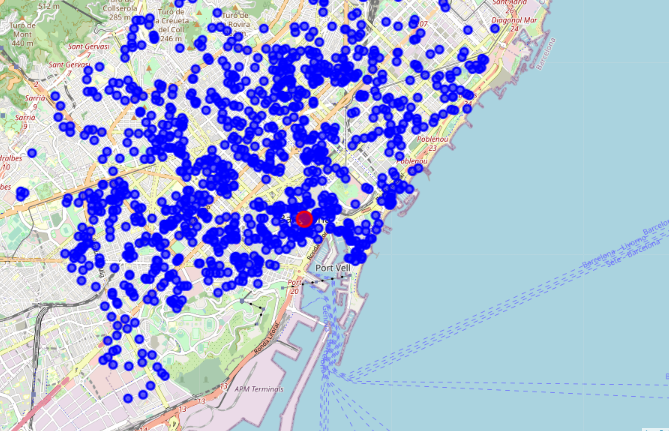

Now let's check the 10 most popular restaurants in Barcelona

In [35]:
bcn_popular_food=bcn_data_filtered_final.groupby('categories').size().reset_index(name='Count')
bcn_popular_food.sort_values(by='Count',ascending=False).head(10)

,categories,Count
67,Restaurant,229
73,Spanish Restaurant,153
53,Mediterranean Restaurant,145
21,Chinese Restaurant,56
5,Asian Restaurant,44
7,Bar,42
79,Tapas Restaurant,39
47,Japanese Restaurant,34
46,Italian Restaurant,31
27,Diner,22


## Methodology <a name="methodology"></a>

The aim of this project is to find the best neighborhood of Barcelona to open a new Italian restaurant.
	
The total number of neighborhoods in Barcelona are 73 so we need to find a way to cluster them based on their similarities, that are the number and the kind of restaurant. Also It is look like there is not too many Italian restaurant so it might be a good decision to open a new one.

In order to clustering the neighborhoods we will use the approach of K-Means algorithm to extract the clusters, produce a map and make an argument on the final result.
The first step in this algorithm it is determinate the best "$ k $", so we will use the analytical approach of the elbow method.

## Analysis <a name="analysis"></a>

We also analyze the frequency of each type of restaurant in all the neighborhoods.

In [36]:
# one hot encoding
bcn_onehot = pd.get_dummies(bcn_data_filtered_final[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bcn_onehot['Neighborhood'] = bcn_data_filtered_final['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bcn_onehot.columns[-1]] + list(bcn_onehot.columns[:-1])
bcn_onehot = bcn_onehot[fixed_columns]

bcn_onehot.head()

,Neighborhood,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bar,Beer Garden,...,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wine Bar,Winery
0,Diagonal Mar i el Front Marítim del Poblenou,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,el Poblenou,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Porta,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,la Maternitat i Sant Ramon,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,les Corts,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
bcn_grouped = bcn_onehot.groupby('Neighborhood').mean().reset_index()
bcn_grouped

,Neighborhood,African Restaurant,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,BBQ Joint,Bar,Beer Garden,...,Sushi Restaurant,Swiss Restaurant,Syrian Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Wine Bar,Winery
0,Baró de Viver,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,...,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
1,Can Baró,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,...,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
2,Canyelles,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,...,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
3,Diagonal Mar i el Front Marítim del Poblenou,0.0,0.0,0.0,0.0,0.0,0.040000,0.0,0.080000,0.04,...,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
4,Farró,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,...,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,la Vila de Gràcia,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.090909,0.00,...,0.000000,0.0,0.0,0.00,0.0,0.030303,0.000000,0.0,0.0,0.0
66,les Corts,0.0,0.0,0.0,0.0,0.0,0.045455,0.0,0.045455,0.00,...,0.022727,0.0,0.0,0.00,0.0,0.000000,0.022727,0.0,0.0,0.0
67,les Planes,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,...,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0
68,les Roquetes,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00,...,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000,0.0,0.0,0.0


Now let's check the shape

In [38]:
neighborhood_unique=pd.DataFrame(bcn_grouped["Neighborhood"].unique())
neighborhood_unique.shape

(70, 1)

Now we can start with the analytic approach. The first step is find the k using the elbow method

In [39]:
bcn_clustering=bcn_grouped.drop('Neighborhood',1)

/home/leonpb/anaconda3/lib/python3.7/site-packages/yellowbrick/utils/kneed.py:155: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/home/leonpb/anaconda3/lib/python3.7/site-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)
/home/leonpb/anaconda3/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


<bound method Visualizer.poof of KElbowVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbd465eec50>,
                 estimator=KMeans(algorithm='auto', copy_x=True,
                                  init='k-means++', max_iter=300, n_clusters=9,
                                  n_init=10, n_jobs=None,
                                  precompute_distances='auto',
                                  random_state=None, tol=0.0001, verbose=0),
                 k=None, locate_elbow=True, metric='distortion', timings=True)>

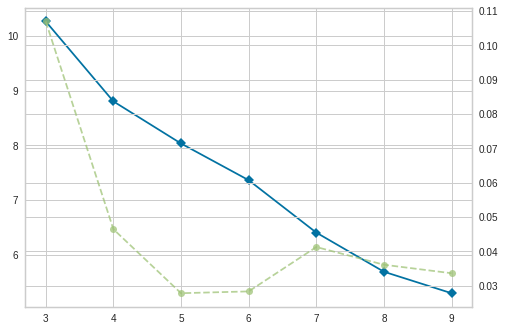

In [40]:


model=KMeans()

visualizer=KElbowVisualizer(model,k=(3,10))
visualizer.fit(bcn_clustering)
visualizer.poof

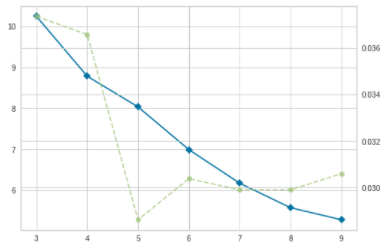

Now we do the clustering method with k=5

In [ ]:
##### set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bcn_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

We check the first 5 rows

In [42]:
neighborhood_unique.head()

,0
0,Baró de Viver
1,Can Baró
2,Canyelles
3,Diagonal Mar i el Front Marítim del Poblenou
4,Farró


Now we add the cluster labels

In [43]:

neighborhood_cluster=neighborhood_unique
neighborhood_cluster.insert(0, 'Cluster Labels', kmeans.labels_)

In [44]:
neighborhood_cluster.head()

,Cluster Labels,0
0,2,Baró de Viver
1,0,Can Baró
2,1,Canyelles
3,1,Diagonal Mar i el Front Marítim del Poblenou
4,0,Farró


We add the latitude and longitude for each neighborhood

In [45]:
neighborhood_cluster.columns=['Cluster Labels', 'Neighborhood']

In [46]:
geolocator=Nominatim(user_agent='bcn_geocoder')
lon=[]
lat=[]
for index, row in neighborhood_cluster.iterrows():
 location=geolocator.geocode(row['Neighborhood']+',Barcelona')
 lon.append(location.longitude)
 lat.append(location.latitude)

In [47]:
neighborhood_cluster['Latitude']=lat
neighborhood_cluster['Longitude']=lon
neighborhood_cluster.head()


,Cluster Labels,Neighborhood,Latitude,Longitude
0,2,Baró de Viver,41.449947,2.199539
1,0,Can Baró,41.416092,2.162402
2,1,Canyelles,41.285827,1.722274
3,1,Diagonal Mar i el Front Marítim del Poblenou,41.405228,2.213352
4,0,Farró,41.403693,2.147284


## Results <a name="results"></a>

We create a map of Barcelona to see the clusters

In [48]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighborhood_cluster['Latitude'], neighborhood_cluster['Longitude'], neighborhood_cluster['Neighborhood'], neighborhood_cluster['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)


folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='yellow',
    popup='Barcelona center',
    fill = True,
    fill_color = 'yellow',
    fill_opacity = 0.6
).add_to(map_clusters)
       
map_clusters

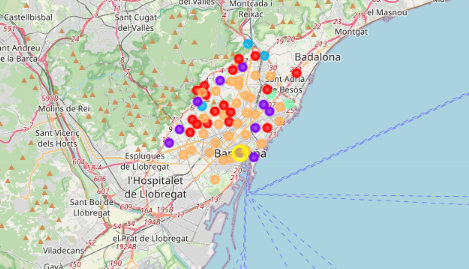

## Analyzing clusters

We start extracting the neighborhoods in each cluster, and also the latitude and longitude

In [49]:
label_0=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==0]['Neighborhood'])
label_1=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==1]['Neighborhood'])
label_2=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==2]['Neighborhood'])
label_3=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==3]['Neighborhood'])
label_4=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==4]['Neighborhood'])

In [50]:
label_0['Latitude']=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==0]['Latitude'])
label_0['Longitude']=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==0]['Longitude'])
label_1['Latitude']=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==1]['Latitude'])
label_1['Longitude']=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==1]['Longitude'])
label_2['Latitude']=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==2]['Latitude'])
label_2['Longitude']=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==2]['Longitude'])
label_3['Latitude']=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==3]['Latitude'])
label_3['Longitude']=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==3]['Longitude'])
label_4['Latitude']=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==4]['Latitude'])
label_4['Longitude']=pd.DataFrame(neighborhood_cluster.loc[neighborhood_cluster["Cluster Labels"]==4]['Longitude'])

Using that we do a single data frame for each cluster with the neighborhoods in each cluster

### Cluster 1

In [51]:
cluster_1=pd.DataFrame()
for index, row in label_0.iterrows():
    restaurants=bcn_data_filtered_final.loc[bcn_data_filtered_final["Neighborhood"]==row['Neighborhood']]
    cluster_1=pd.concat([cluster_1,restaurants],axis=0)
cluster_1.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id,Neighborhood
361,Bar Restaurant Casa Jin,Restaurant,"Av. Mare de Deu de Montserrat, 29",41.414135,2.162264,"[{'label': 'display', 'lat': 41.414135, 'lng':...",218,08024,ES,Barcelona,Cataluña,España,"[Av. Mare de Deu de Montserrat, 29, 08024 Barc...",5cb9b174356b49002c0e085d,Can Baró
365,Restaurante Jardi de L'Apat,None,"Albert Llamas, 2",41.415155,2.159719,"[{'label': 'display', 'lat': 41.41515487965063...",247,NaN,ES,Barcelona,Cataluña,España,"[Albert Llamas, 2, Barcelona Cataluña, España]",4e627b0ee4cdf1e2bf52f718,Can Baró
481,Restaurant Azul,Modern European Restaurant,Padua 108,41.403355,2.143384,"[{'label': 'display', 'lat': 41.40335464477539...",441,08006,ES,Barcelona,Cataluña,España,"[Padua 108, 08006 Barcelona Cataluña, España]",53f5dd67498ea900654caedc,Farró
486,Restaurante Tuttopasta,Italian Restaurant,"Santjoanistes, 28",41.402030,2.146542,"[{'label': 'display', 'lat': 41.40203, 'lng': ...",643,08006,ES,Barcelona,Cataluña,España,"[Santjoanistes, 28, 08006 Barcelona Cataluña, ...",4b749c74f964a520ace72de3,Farró
487,Restaurante Xewi,Restaurant,C. Sant Elies,41.401724,2.146945,"[{'label': 'display', 'lat': 41.40172359969239...",688,NaN,ES,Barcelona,Cataluña,España,"[C. Sant Elies, Barcelona Cataluña, España]",4d51a97cbd6ff04de400f40c,Farró


Let's check the 10 most popular categories

In [52]:
cluster_1_popular_food=cluster_1.groupby('categories').size().reset_index(name='Count')
cluster_1_popular_food.sort_values(by='Count',ascending=False).head(10)

,categories,Count
22,Restaurant,37
25,Spanish Restaurant,12
16,Mediterranean Restaurant,6
3,Breakfast Spot,4
6,Chinese Restaurant,3
13,Indian Restaurant,2
12,Hotel,2
21,Pizza Place,2
15,Japanese Restaurant,2
14,Italian Restaurant,2


### Cluster 2

In [53]:
cluster_2=pd.DataFrame()
for index, row in label_1.iterrows():
    restaurants=bcn_data_filtered_final.loc[bcn_data_filtered_final["Neighborhood"]==row['Neighborhood']]
    cluster_2=pd.concat([cluster_2,restaurants],axis=0)
    
cluster_2.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id,Neighborhood
301,Restaurante 5 Hermanos,Mediterranean Restaurant,"Federico García Lorca, 31",41.444106,2.165911,"[{'label': 'display', 'lat': 41.44410555164136...",565,08042,ES,Barcelona,Cataluña,España,"[Federico García Lorca, 31, 08042 Barcelona Ca...",4bcc5e11937ca593c3eeaa92,Canyelles
0,ristoante italian fusion,Italian Restaurant,NaN,41.410623,2.213432,"[{'label': 'display', 'lat': 41.410623, 'lng':...",486,NaN,ES,NaN,NaN,España,[España],57ab4762498ea54ad096686e,Diagonal Mar i el Front Marítim del Poblenou
33,Restaurant Siberia,Spanish Restaurant,Selva de Mar 84,41.411146,2.206173,"[{'label': 'display', 'lat': 41.41114643740437...",192,08019,ES,Barcelona,Cataluña,España,"[Selva de Mar 84 (Cristobal de Moura), 08019 B...",4d7e19ca95c1a143ed84caf2,Diagonal Mar i el Front Marítim del Poblenou
46,Restaurante Dia,Spanish Restaurant,NaN,41.410211,2.218577,"[{'label': 'display', 'lat': 41.4102114086185,...",660,NaN,ES,NaN,NaN,España,[España],50e7df4ee4b0fe07cee9eec2,Diagonal Mar i el Front Marítim del Poblenou
49,Bar Restaurant Angel,Spanish Restaurant,paseo taulat,41.405051,2.213004,"[{'label': 'display', 'lat': 41.40505146431758...",35,NaN,ES,Barcelona,Cataluña,España,"[paseo taulat, Barcelona Cataluña, España]",4e89d16a0aaf7f40fd2851b3,Diagonal Mar i el Front Marítim del Poblenou


Let's check the 10 most popular categories

In [54]:
cluster_2_popular_food=cluster_2.groupby('categories').size().reset_index(name='Count')
cluster_2_popular_food.sort_values(by='Count',ascending=False).head(10)

,categories,Count
29,Mediterranean Restaurant,56
39,Spanish Restaurant,42
37,Restaurant,41
41,Tapas Restaurant,8
25,Italian Restaurant,7
1,Asian Restaurant,7
34,Paella Restaurant,7
3,Bar,6
38,Seafood Restaurant,6
26,Japanese Restaurant,4


### Cluster 3

In [55]:
cluster_3=pd.DataFrame()
for index, row in label_2.iterrows():
    restaurants=bcn_data_filtered_final.loc[bcn_data_filtered_final["Neighborhood"]==row['Neighborhood']]
    cluster_3=pd.concat([cluster_3,restaurants],axis=0)
    
cluster_3.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id,Neighborhood
275,"Restaurante ""Gavisé""",Spanish Restaurant,"Carrer de Clariana, 33-35",41.447157,2.200350,"[{'label': 'display', 'lat': 41.44715666770935...",317,08030,ES,Barcelona,Cataluña,España,"[Carrer de Clariana, 33-35, 08030 Barcelona Ca...",4c5808792308be9a3c625a6c,Baró de Viver
284,Restaurante El Cordero,Spanish Restaurant,"Serra de Collserola Nal Park, Carrer det Riude...",41.452670,2.180062,"[{'label': 'display', 'lat': 41.45267027899003...",435,08042,ES,Barcelona,Cataluña,España,"[Serra de Collserola Nal Park, Carrer det Riud...",4e31bb0b45dd720580b171be,Torre Baró
458,restaurante Prince,Spanish Restaurant,NaN,41.412193,2.148900,"[{'label': 'display', 'lat': 41.412193, 'lng':...",424,NaN,ES,NaN,NaN,España,[España],4ee3c9b1e4b059cb773ec8c2,Vallcarca i els Penitents


Let's check the categories

In [56]:
cluster_3_popular_food=cluster_3.groupby('categories').size().reset_index(name='Count')
cluster_3_popular_food.sort_values(by='Count',ascending=False).head(10)

,categories,Count
0,Spanish Restaurant,3


### Cluster 4

In [57]:
cluster_4=pd.DataFrame()
for index, row in label_3.iterrows():
    restaurants=bcn_data_filtered_final.loc[bcn_data_filtered_final["Neighborhood"]==row['Neighborhood']]
    cluster_4=pd.concat([cluster_4,restaurants],axis=0)
    
cluster_4.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id,Neighborhood
280,Restaurant La Font,Food,NaN,41.465404,2.179867,"[{'label': 'display', 'lat': 41.46540356609677...",394,NaN,ES,NaN,NaN,España,[España],4de231ba45dd180ae540140b,Vallbona
42,Royal Tandoori Restaurant and cafe,Asian Restaurant,"AV.Alfonso XIII 554-56,",41.415585,2.220912,"[{'label': 'display', 'lat': 41.41558522322383...",591,08913,ES,Barcelona,Cataluña,España,"[AV.Alfonso XIII 554-56, (Badalona,), 08913 Ba...",4e46a56e814d84e76a9a5afb,la Mina
21,Restaurante Casa Suso,Food,"Carrer de ca n'Oliva, 69",41.424102,2.204519,"[{'label': 'display', 'lat': 41.42410237086280...",164,08020,ES,Barcelona,Cataluña,España,"[Carrer de ca n'Oliva, 69, 08020 Barcelona Cat...",4e1eeff7ae60cd553debd533,la Pau
22,Restaurante Chino Ta viang dao,Asian Restaurant,NaN,41.421795,2.205835,"[{'label': 'display', 'lat': 41.42179497479602...",289,NaN,ES,NaN,NaN,España,[España],51af3519498ee8754e5f22e3,la Pau


Let's check the categories

In [58]:
cluster_4_popular_food=cluster_4.groupby('categories').size().reset_index(name='Count')
cluster_4_popular_food.sort_values(by='Count',ascending=False).head(10)

,categories,Count
0,Asian Restaurant,2
1,Food,2


### Cluster 5

In [59]:
cluster_5=pd.DataFrame()
for index, row in label_4.iterrows():
    restaurants=bcn_data_filtered_final.loc[bcn_data_filtered_final["Neighborhood"]==row['Neighborhood']]
    cluster_5=pd.concat([cluster_5,restaurants],axis=0)
    
cluster_5.head()

,name,categories,address,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id,Neighborhood
492,restaurant santalo 113,Restaurant,Santalo 113,41.396570,2.144143,"[{'label': 'display', 'lat': 41.39656965, 'lng...",151,NaN,ES,Barcelona,Cataluña,España,"[Santalo 113, Barcelona Cataluña, España]",4b8e7190f964a520f32233e3,Galvany
494,Restaurant Meating,Restaurant,NaN,41.396829,2.142566,"[{'label': 'display', 'lat': 41.396829, 'lng':...",128,NaN,ES,NaN,NaN,España,[España],58bff11a55d6221835932c6a,Galvany
495,Restaurant Japonès J8,Japanese Restaurant,"Marià Cubí, 179",41.395301,2.145189,"[{'label': 'display', 'lat': 41.39530104454578...",316,08021,ES,Barcelona,Cataluña,España,"[Marià Cubí, 179 (Amigó), 08021 Barcelona Cata...",4c76731bc219224bd533a528,Galvany
496,Restaurante Café Madrazo,Mediterranean Restaurant,"Madrazo, 50",41.399488,2.147856,"[{'label': 'display', 'lat': 41.39948840282839...",417,08006,ES,Barcelona,Cataluña,España,"[Madrazo, 50, 08006 Barcelona Cataluña, España]",4c51773c0ef3a593f195087c,Galvany
497,Restaurant Roma,Mediterranean Restaurant,"Alfons XII, 41",41.399178,2.148801,"[{'label': 'display', 'lat': 41.39917762103506...",477,08006,ES,Barcelona,Cataluña,España,"[Alfons XII, 41, 08006 Barcelona Cataluña, Esp...",4bbf82d4f8219c74e619b010,Galvany


Let's check the 10 most common categories

In [60]:
cluster_5_popular_food=cluster_5.groupby('categories').size().reset_index(name='Count')
cluster_5_popular_food.sort_values(by='Count',ascending=False).head(10)

,categories,Count
63,Restaurant,144
69,Spanish Restaurant,93
50,Mediterranean Restaurant,80
20,Chinese Restaurant,51
7,Bar,34
5,Asian Restaurant,32
75,Tapas Restaurant,28
44,Japanese Restaurant,28
43,Italian Restaurant,22
16,Café,18


### Distance to the center 

We choosed Cluster 2 and Cluster 5 as possible locations, now let's check the distntance in each neighborhood in the clusters and the restaurants there

In [61]:
# longitude and latitude to utm 
def lonlat_to_xy(lon, lat):
    proj_latlon = pyproj.Proj(proj='latlong',datum='WGS84')
    proj_xy = pyproj.Proj(proj="utm", zone=31, datum='WGS84')
    xy = pyproj.transform(proj_latlon, proj_xy, lon, lat)
    return xy[0], xy[1]

In [62]:
# cartesian distance
def calc_xy_distance(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    return math.sqrt(dx*dx + dy*dy)

utm points of the city center

In [ ]:
center_x,center_y=lonlat_to_xy(longitude,latitude)

### Cluster 2

Distances of the neighborhoods

In [ ]:
distances_to_center_cluster_2 = []

for lat, lng in zip(label_1.Latitude,label_1.Longitude):
    
    x,y=lonlat_to_xy(lng,lat)
    d = calc_xy_distance(x, y, center_x, center_y)
    
    distances_to_center_cluster_2.append(d)
    
label_1['Distances']=distances_to_center_cluster_2

In [65]:
label_1['Distances']

2     39584.277831
3      3894.471740
7      5772.621671
10     5511.820557
12     3922.353529
18     4144.572656
20      345.168480
22     5020.546333
39       70.598895
40     2296.787147
41     2821.179667
46     5148.935413
48     1074.042898
55     6601.346096
Name: Distances, dtype: float64

Minimal distance to the city center

In [66]:
min(label_1['Distances'])

70.59889536078404

Neighborhood closest to the city center

In [67]:
label_1.loc[label_1['Distances']==min(label_1['Distances'])]['Neighborhood']

39    el Gòtic
Name: Neighborhood, dtype: object

Venues categories in el Gòtic

In [68]:
elGotic_popular_food=bcn_data_filtered_final.loc[bcn_data_filtered_final['Neighborhood']=='el Gòtic'].groupby('categories').size().reset_index(name='Count')
elGotic_popular_food.sort_values(by='Count',ascending=False).head(10)

,categories,Count
7,Mediterranean Restaurant,11
13,Spanish Restaurant,10
12,Restaurant,6
6,Italian Restaurant,3
9,Paella Restaurant,2
15,Tapas Restaurant,2
0,Bar,1
1,Café,1
2,Diner,1
3,Gluten-free Restaurant,1


We also check the secong neighborhood closer to the center: Santa Caterina

In [73]:
SantaCaterina_popular_food=bcn_data_filtered_final.loc[bcn_data_filtered_final['Neighborhood']=='Santa Caterina'].groupby('categories').size().reset_index(name='Count')
SantaCaterina_popular_food.sort_values(by='Count',ascending=False)

,categories,Count
3,Restaurant,2
4,Spanish Restaurant,2
0,Bar,1
1,Italian Restaurant,1
2,Mediterranean Restaurant,1


### Cluster 5

Distances of the neighborhoods

In [ ]:
distances_to_center_cluster_5 = []

for lat, lng in zip(label_4.Latitude,label_4.Longitude):
    
    x,y=lonlat_to_xy(lng,lat)
    d = calc_xy_distance(x, y, center_x, center_y)
    
    distances_to_center_cluster_5.append(d)
    
label_4['Distances']=distances_to_center_cluster_5

In [70]:
label_4['Distances']

5      3181.637985
6      3195.485961
9     62528.370793
11     5585.090401
13     6087.545847
14     1401.222932
19    25059.617926
21     2795.772779
26     6790.030261
27     5233.204112
29     4687.322844
30     6335.772689
32     3125.719987
33     5100.397430
34     3205.957561
35    34957.592773
37     1503.427678
38     3881.048304
42     3879.467563
43      845.590253
44     5537.032607
45     4453.637587
47     2034.804991
49     1596.424780
51     4344.861552
53     2378.069748
56      503.878118
57     2299.342129
58     4328.932901
62     5508.208091
64     1798.463504
65     2818.245370
66     3735.880074
Name: Distances, dtype: float64

Minimal distance to the city center

In [71]:
min(label_4['Distances'])

503.8781184768025

Closest neighborhood to the city center

In [72]:
label_4.loc[label_4['Distances']==min(label_4['Distances'])]['Neighborhood']

56    la Ribera
Name: Neighborhood, dtype: object

Venues categories in la Ribera

In [74]:
SantaCaterina_popular_food=bcn_data_filtered_final.loc[bcn_data_filtered_final['Neighborhood']=='la Ribera'].groupby('categories').size().reset_index(name='Count')
SantaCaterina_popular_food.sort_values(by='Count',ascending=False)

,categories,Count
6,Mediterranean Restaurant,4
13,Tapas Restaurant,3
7,Mexican Restaurant,2
10,Restaurant,2
11,Seafood Restaurant,2
12,Spanish Restaurant,2
0,Argentinian Restaurant,1
1,Breakfast Spot,1
2,Café,1
3,Cantonese Restaurant,1


## Discussion <a name="discussion"></a>

So we have two good locations, la Ribera has more restaurants but tere is not an Italian restaurant. In Santa Caterina there is one Italian restaurant but there are less restaurant and it is closer to the center, so now it deppends on the preferences on the criteria.

Finally we have to say that all the data obtained using the Foursquare API is not very useful in Barcelona because it has not the venues with the required accuracy and it is not updated.

Also, some restaurants has not categories assigned, so we loose some information too. Most of them are categorized as Restaurant, so doesn't know what kind of restaurant is.

## Conclusion <a name="conclusion"></a>

In this work we used differents tool with the aim of finding an optimal location for a new Italian restaurants in Barcelona, Spain. This is a well known city because it is one of the most visited cities in the world by international visitors.
With this in mind we used different data sources to obtain the requiered information. One of them it is the Foursquare API, in this case this in not a good source because it is not updated and it is not very accurate. So, although we found two good locations, this two locations might not be the good ones actually.\\
If i would like to open a new Italian restaurant i would not use that data source, instead we have the Barcelona Restaurant Open Data updated weekely: https://opendata-ajuntament.barcelona.cat/data/dataset/equipament-restaurants.